## 5.2 Chain rule

$$ z = t^2 $$
$$ t = x + y $$

$$ \frac{\partial z}{\partial t} = 2t $$
$$ \frac{\partial t}{\partial x} = 1 $$

$$ \frac{\partial z}{\partial x} = \frac{\partial z}{\partial t} \frac{\partial t}{\partial x} = 2(x+y)$$

## 5.4 단순 계층 구현

In [1]:
import numpy as np

In [2]:
# 곱셈 계층

class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout):
        # x와 y를 바꾼다
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy

In [3]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

round(price)

220

In [4]:
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print('dapple: ', dapple)
print('dapple_num: ', round(dapple_num))
print('tax: ', round(dtax))

dapple:  2.2
dapple_num:  110
tax:  200


In [5]:
# 덧셈 계층

class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [6]:
ap = 100
ap_num = 2
og = 150
og_num = 3
tax = 1.1

mul_ap = MulLayer()
mul_og = MulLayer()
add_two = AddLayer()
mul_tax = MulLayer()

# forward
ap_pr = mul_ap.forward(ap, ap_num)
og_pr = mul_og.forward(og, og_num)
sum_pr = add_two.forward(ap_pr, og_pr)
result = mul_tax.forward(sum_pr, tax)

print('result: ', round(result))


# backward
dresult = 1

dsum_pr, dtax = mul_tax.backward(dresult)

dap_pr, dog_pr = add_two.backward(dsum_pr)

dap, dap_num = mul_ap.backward(dap_pr)

dog, dog_num = mul_og.backward(dog_pr)

for i in [dresult, dsum_pr, dtax, dap_pr, dog_pr, dap, dap_num, dog, dog_num]:
    print(round(i, 2))

result:  715
1
1.1
650
1.1
1.1
2.2
110.0
3.3
165.0


## 5.5 활성화 함수 계층 구현

### ReLU

$ y = $
$$x(x>0)$$
$$0(x<0)$$
$\frac{\partial y}{\partial x}=$
$$1(x>0)$$
$$0(x<0)$$

In [7]:
# ReLU 계층

class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

In [8]:
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)

[[ 1.  -0.5]
 [-2.   3. ]]


In [9]:
mask = (x <= 0)
print(mask)

[[False  True]
 [ True False]]


In [10]:
x[mask]

array([-0.5, -2. ])

### Sigmoid

$$y = \frac{1}{1 + exp(-x)}$$

$$\frac{\partial L}{\partial y} y^2 exp(-x) = \frac{\partial L}{\partial y}y(1-y)$$
$$\sigma ' = \sigma (1 - \sigma)$$

In [11]:
# Sigmoid 계층

class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out # y(1-y)
        
        return dx

## 5.6 Affine, Softmax 계층 구현

X (2,) * W (2, 3) = Y (3,)
- Affine transformation

$$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \dot\ W^T$$ (2,) = (3,) * (3, 2)
$$\frac{\partial L}{\partial W} = X^T \dot\ \frac{\partial L}{\partial Y}$$ (2, 3) = (2, 1) * (1, 3)
$$X = (x_0, x_1, ... , x_n)$$
$$\frac{\partial L}{\partial X} = (\frac{\partial L}{\partial x_0}, \frac{\partial L}{\partial x_1}, ..., \frac{\partial L}{\partial x_n})$$

### 배치용 Affine 계층 (N개의 데이터 묶음: 배치 input)

X (N, 2) * W (2, 3) = Y (N, 3)
- Affine transformation

$$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \dot\ W^T$$ (N, 2) = (N, 3) * (3, 2)
$$\frac{\partial L}{\partial W} = X^T \dot\ \frac{\partial L}{\partial Y}$$ (2, 3) = (2, N) * (N, 3)

In [12]:
# Broadcasting

X_dot_W = np.array([[0,0,0], [10,10,10]])
B = np.array([1,2,3])
X_dot_W

array([[ 0,  0,  0],
       [10, 10, 10]])

In [13]:
X_dot_W + B

array([[ 1,  2,  3],
       [11, 12, 13]])

In [14]:
dY = np.array([[1,2,3], [4,5,6]])
dY

array([[1, 2, 3],
       [4, 5, 6]])

In [15]:
dB = np.sum(dY, axis=0)
dB

array([5, 7, 9])

In [16]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

In [17]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmax의 출력
        self.t = None # 정답레이블 (one-hot vetor)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

## 5.7 오차역전파 구현

In [18]:
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
            
        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads
    

In [19]:
# gradient checK: 오차역전파 제대로 구현했는지 수치 미분과 비교하여 검증

from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ': ' + str(diff))

W1: 1.9079809195112884e-10
b1: 9.887674774918757e-10
W2: 7.082613854932085e-08
b2: 1.417765360736678e-07


In [23]:
# 오차역전파 사용한 학습 구현

from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('iter: ', i, 'train_acc: ', round(train_acc, 4), '/ test_acc: ', round(test_acc, 4))
        

iter:  0 train_acc:  0.0974 / test_acc:  0.0982
iter:  600 train_acc:  0.7934 / test_acc:  0.7963
iter:  1200 train_acc:  0.8764 / test_acc:  0.8786
iter:  1800 train_acc:  0.8983 / test_acc:  0.9
iter:  2400 train_acc:  0.9085 / test_acc:  0.9118
iter:  3000 train_acc:  0.9146 / test_acc:  0.9201
iter:  3600 train_acc:  0.9194 / test_acc:  0.9216
iter:  4200 train_acc:  0.9245 / test_acc:  0.927
iter:  4800 train_acc:  0.9272 / test_acc:  0.929
iter:  5400 train_acc:  0.9306 / test_acc:  0.9306
iter:  6000 train_acc:  0.9333 / test_acc:  0.9336
iter:  6600 train_acc:  0.9363 / test_acc:  0.9358
iter:  7200 train_acc:  0.9389 / test_acc:  0.9383
iter:  7800 train_acc:  0.9418 / test_acc:  0.9397
iter:  8400 train_acc:  0.944 / test_acc:  0.9436
iter:  9000 train_acc:  0.9454 / test_acc:  0.9438
iter:  9600 train_acc:  0.9478 / test_acc:  0.9462


In [26]:
train_size

60000

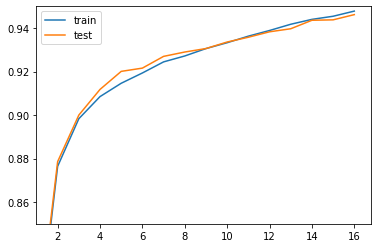

In [48]:
import matplotlib.pyplot as plt

plt.plot(train_acc_list, label='train')
plt.plot(test_acc_list, label='test')
plt.ylim(0.85, 0.95)
plt.xlim(1)
plt.legend()
plt.show()